In [1]:
import tensorflow as tf

print(tf.__version__)

2.16.1


In [2]:
var = tf.Variable([0.0, 0.0, 0.0])
print(var)
var.assign([1, 2, 3])
print(var)
var.assign_add([1, 1, 1])
print(var)

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>


In [3]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

print(f(x))

tf.Tensor(-2.0, shape=(), dtype=float32)


In [4]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx
print(g_x)

tf.Tensor(4.0, shape=(), dtype=float32)


In [6]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

x = tf.constant([1, 2, 3])
print(my_func(x))
x = tf.constant([10, 9, 8])
print(my_func(x))
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
print(my_func(x))

Tracing.

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(27, shape=(), dtype=int32)
Tracing.

tf.Tensor(27.3, shape=(), dtype=float32)


In [9]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

In [10]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved\assets


INFO:tensorflow:Assets written to: ./saved\assets


In [11]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

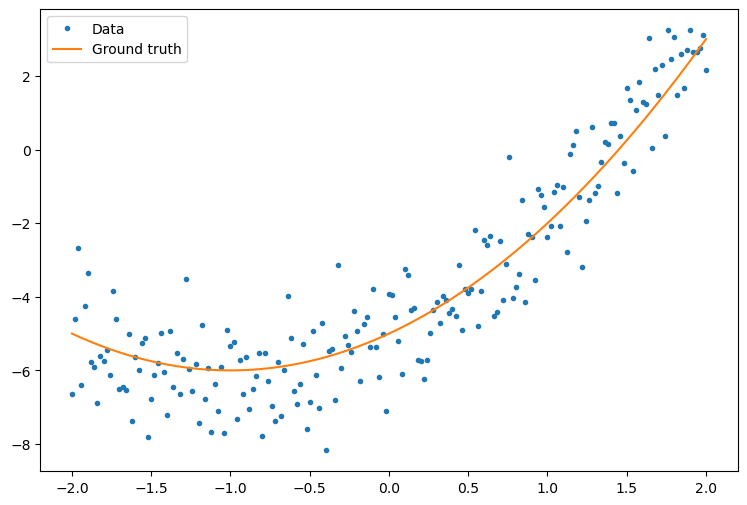

In [13]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

In [14]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

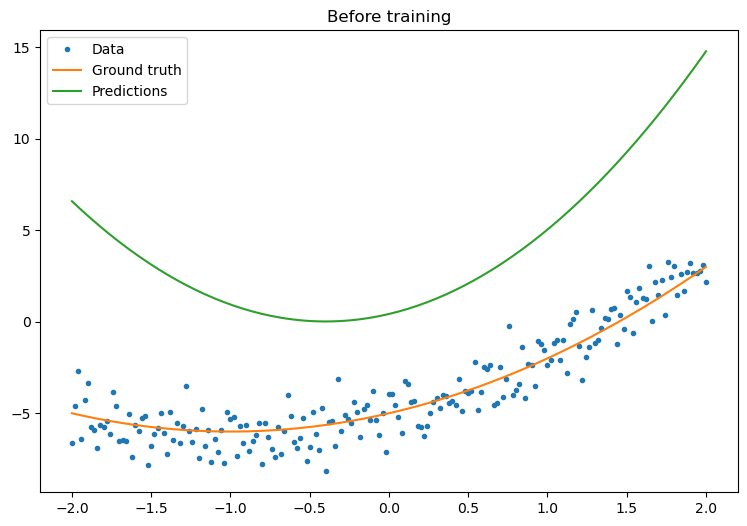

In [21]:
quad_model = Model()

def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

plot_preds(x, y, f, quad_model, 'Before training')

In [22]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

In [23]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 25.287
Mean squared error for step 10: 3.277
Mean squared error for step 20: 1.776
Mean squared error for step 30: 1.248
Mean squared error for step 40: 1.072
Mean squared error for step 50: 1.003
Mean squared error for step 60: 0.982
Mean squared error for step 70: 0.972
Mean squared error for step 80: 0.970
Mean squared error for step 90: 0.969




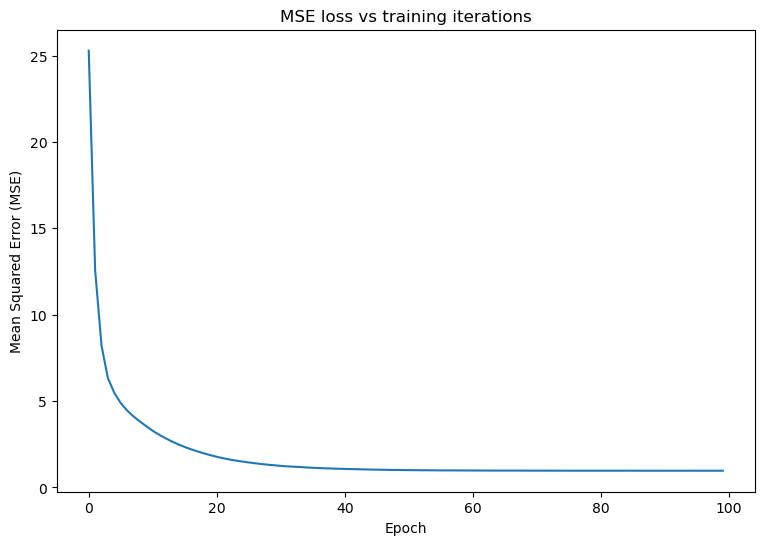

In [24]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

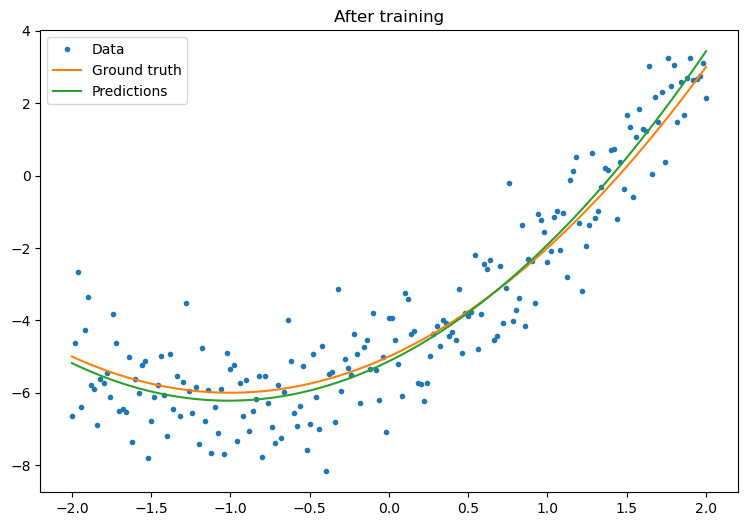

In [25]:
plot_preds(x, y, f, quad_model, 'After training')

In [27]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model.h5')

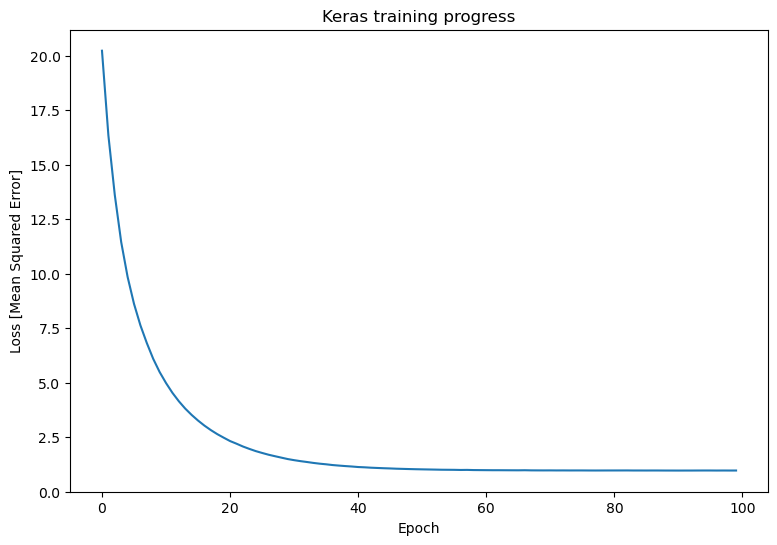

In [28]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

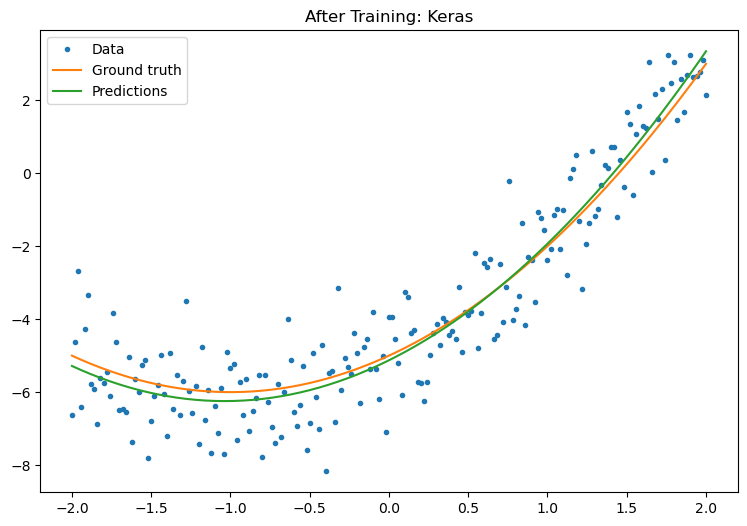

In [29]:
plot_preds(x, y, f, new_model, 'After Training: Keras')

In [30]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)